<h1 style="color: blue; text-align: center; font-size: 25px;"><b>Twitter Sentiment Analysis Web App</b></h1>
<h1 style="color: blue; text-align: center; font-size: 20px;"><b>Using NLP and Streamlit</b></h1>

## Description

This project is a Sentiment Analysis Web App that classifies tweets as positive, negative, or neutral. It leverages Natural Language Processing (NLP) techniques and machine learning models to analyze sentiments in textual data. The app provides an interactive interface built with Streamlit, allowing users to input text and receive sentiment predictions in real-time.

## Aim
The primary objective of this project is to develop a robust sentiment analysis model that accurately classifies textual data using machine learning techniques. It aims to:

* Preprocess and clean raw tweet data for better analysis.
* Implement and compare different classification models, including Logistic Regression, Naïve Bayes, and Artificial Neural Networks (ANN).
* Optimize the best-performing model using hyperparameter tuning.
* Deploy an easy-to-use web application for real-time sentiment prediction.

In [19]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score
# from scipy.sparse import csr_matrix

In [103]:
data=pd.read_csv("tweet_emotions.csv")

In [105]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [107]:
df=data.drop(columns='tweet_id')

In [109]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [111]:
df.duplicated().sum()

91

In [113]:
df.drop_duplicates(inplace= True)

In [115]:
df.duplicated().sum()

0

In [17]:
df.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [117]:
A=df.sentiment.value_counts()
A

sentiment
neutral       8617
worry         8452
happiness     5194
sadness       5160
love          3801
surprise      2187
fun           1776
relief        1524
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

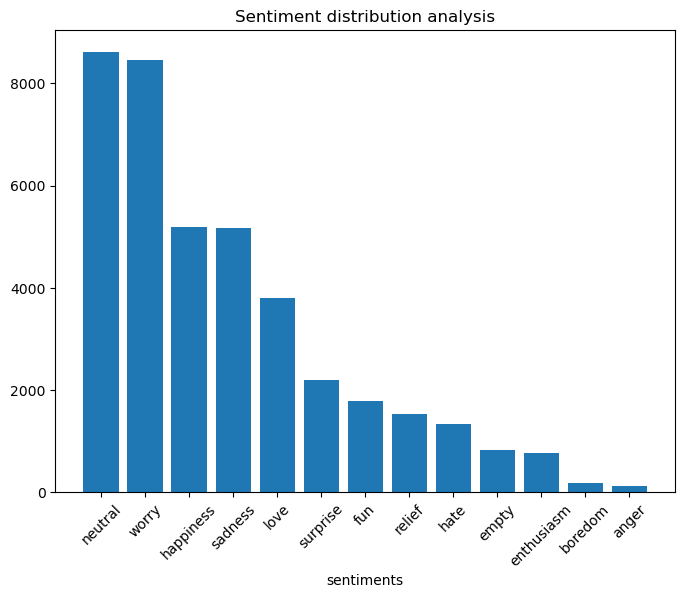

In [35]:
plt.figure(figsize=(8,6))
plt.bar(A.index, A.values)
plt.title("Sentiment distribution analysis")
plt.xlabel("sentiments")
plt.xticks(rotation= 45)
plt.show()

In [119]:
def preprocess_text(text):
    # Preprocessing function
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [121]:
# Apply preprocessing
df['processed_text'] = df['content'].apply(preprocess_text)

In [123]:
df['processed_text'].head()

0    tiffanylue know listenin bad habit earlier sta...
1              layin n bed headache ughhhh waitin call
2                       funeral ceremony gloomy friday
3                                want hang friend soon
4    dannycastillo want trade someone houston ticke...
Name: processed_text, dtype: object

In [191]:
# Encode the 'sentiment' column
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])

In [157]:
df['sentiment_encoded'].head()

0     2
1    10
2    10
3     3
4     8
Name: sentiment_encoded, dtype: int32

In [159]:
vectorizer = TfidfVectorizer(max_features=2000)  # Adjust based on dataset size
X = vectorizer.fit_transform(df['processed_text']).toarray()
y = df['sentiment_encoded']

In [161]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
# 4️⃣ Convert sparse matrix to dense before applying SMOTE
X_train_tfidf_dense = X_train.copy()  # Convert csr_matrix to numpy array

# 5️⃣ Apply SMOTE separately
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf_dense, y_train)

In [164]:
#Scaling
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [139]:

# Define models
models = {
    "Logistic Regression (L1)": LogisticRegression(penalty='l1', solver='liblinear'),
    "Naïve Bayes": MultinomialNB(alpha=20),
}

In [167]:
# Train models **without TfidfVectorizer in the pipeline**
for name, model in models.items():
    model.fit(X_train_scaled, y_train_smote)  # ✅ Train with resampled data
    y_pred = model.predict(X_test_scaled)  # ✅ Predict on already vectorized test data

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression (L1) Accuracy: 0.2214
Naïve Bayes Accuracy: 0.2061


In [169]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5, 10, 20, 50]}

# Initialize Naïve Bayes
nb = MultinomialNB()

# Perform Grid Search with Cross Validation
grid_search = GridSearchCV(nb, param_grid, cv=3, scoring='accuracy', n_jobs=1)

grid_search.fit(X_train_scaled, y_train_smote)

# Best parameter
print("Best alpha:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

# Train with best alpha
best_nb = MultinomialNB(alpha=grid_search.best_params_['alpha'])
best_nb.fit(X_train_scaled,y_train_smote)

# Predict and evaluate
y_pred = best_nb.predict(X_test_scaled)


Best alpha: {'alpha': 0.01}
Best accuracy: 0.47705355679236


In [73]:
# # from sklearn.linear_model import LogisticRegression
# # from sklearn.model_selection import GridSearchCV

# # Define parameter grid
# param_grid = {
#     "C": [ 0.01, 0.1, 1],  # Regularization strength
#     "solver": ["liblinear", "saga"],  # Solvers that support L1
#     "max_iter": [100, 500]  # Increase iterations for convergence
# }

# # Initialize Logistic Regression
# log_reg = LogisticRegression(penalty='l1')

# # Perform Grid Search with 5-fold cross-validation
# grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
# grid_search.fit(X_train_scaled,y_train_smote)  # Replace X_train, y_train with your dataset

# # Print best parameters and best accuracy
# print("Best Parameters:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)


In [143]:
y_test.head()

21502     5
37365     5
5289     12
13857     8
27655    10
Name: sentiment_encoded, dtype: int32

In [145]:
y_pred=pd.DataFrame(y_pred)

In [147]:
y_pred.head()

,0
0,7
1,4
2,9
3,2
4,2


In [83]:
# from sklearn.linear_model import LogisticRegression

# log_reg = LogisticRegression(max_iter=1000)
# log_reg.fit(X_train_scaled, y_train_smote)
# y_pred_lr = log_reg.predict(X_test_scaled)

In [85]:
# print(f"accuracy = {accuracy_score(y_test,y_pred_lr)}")

In [398]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [400]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(7, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Change to softmax if multiclass
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [402]:
# Train the model
history = model.fit(X_train_scaled, y_train_smote, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.0752 - loss: -1369.0919 - val_accuracy: 0.0048 - val_loss: -30931.9844
Epoch 2/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0759 - loss: -37457.4023 - val_accuracy: 0.0048 - val_loss: -178699.0781
Epoch 3/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.0756 - loss: -155340.9375 - val_accuracy: 0.0048 - val_loss: -485333.4688
Epoch 4/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.0780 - loss: -377359.7188 - val_accuracy: 0.0048 - val_loss: -986661.3125
Epoch 5/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.0781 - loss: -730189.5000 - val_accuracy: 0.0048 - val_loss: -1723762.0000
Epoch 6/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.0758 - loss: -1242321.6250 - val_accuracy: 0.0048 - val_loss: -2737669.5000
Epoch 7/100
2782/2782 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.0795 - loss: -1935441.0000 - val_accuracy: 0.0048 - val_loss: -4061

In [406]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0049 - loss: -6377740800.0000
Test Accuracy: 0.0048


In [183]:
# Initialize Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [ ]:
# pipeline.fit(X_train_smote,y_train_smote)

In [193]:

# Take user input
new_review = input("Enter your statement: ")
new_review_cleaned = [preprocess_text(new_review)]  # Preprocess input text
new_review_vectorized = vectorizer.transform(new_review_cleaned)  # Vectorize input

# Make a prediction
prediction = best_nb.predict(new_review_vectorized)

# Ensure the prediction is in the correct format
if prediction.ndim > 1:
    prediction = prediction.ravel()

# Convert numerical prediction back to original sentiment label
predicted_sentiment = le.inverse_transform(prediction)

print("Predicted Sentiment:", predicted_sentiment[0])


Enter your statement:  I hate you


Predicted Sentiment: hate


In [195]:
import pickle

# Save model
with open("sentiment_model1.pkl", "wb") as best_model_file:
    pickle.dump(best_nb, best_model_file)

# Save TF-IDF vectorizer
with open("vectorizer1.pkl", "wb") as best_vec_file:
    pickle.dump(vectorizer, best_vec_file)

# Save LabelEncoder
with open("label_encoder.pkl", "wb") as label_file:
    pickle.dump(le, label_file)